<a href="https://colab.research.google.com/github/ekomation/research/blob/main/External.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline 
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df.iloc[:, :-1], label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score


classifiers = ['Random Forest', 'Support vector Machine', 'KNeighbors']



In [33]:
models = [RandomForestClassifier(),
          svm.SVC(kernel='rbf'),
          KNeighborsClassifier()]

In [34]:
def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
   # X = df.iloc[:, : -1]
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1     
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    #joblib.dump(model, 'diabetes_prediction_model.joblib')
    return Score


In [35]:
def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [36]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)     
        chromosome[:int(0.3*n_feat)]=False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population



In [37]:
def fitness_score(population):
    scores = []
    for chromosome in population:
      rf = RandomForestClassifier()
      rf.fit(X_train.iloc[:,chromosome],Y_train)         
      predictions = rf.predict(X_test.iloc[:,chromosome])
      scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds,:][::-1]) 



In [38]:
def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


In [39]:
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen


In [40]:
def mutation(pop_after_cross,mutation_rate,n_feat):   
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = [] 
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]  
        pop_next_gen.append(chromo)
    return pop_next_gen

In [42]:
def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

In [43]:
from google.colab import files
uploaded = files.upload()

Saving diabetes_data.csv to diabetes_data (1).csv


In [44]:
data_db = pd.read_csv("diabetes_data.csv").sample(frac = 1).reset_index(drop = True).drop([])
label_db = data_db["CLASS"]


print("Diabetes disease dataset:\n",data_db.shape[0],"Records\n",data_db.shape[1],"Features")


Diabetes disease dataset:
 1000 Records
 14 Features


In [45]:
#data cleaning
data_db['CLASS'] = [2 if CLASS.strip() == 'Y' else 0 if CLASS.strip() == 'N' else 1 for CLASS in data_db['CLASS']]
data_db['Gender'] = [0 if Gender.strip() in ['f', 'F'] else 1 if Gender.strip() == 'M' else None for Gender in data_db['Gender']]

In [ ]:
head = data_db.head(8)
tail = data_db.tail(8)
cross_section = pd.concat([head, tail])

In [ ]:
cross_section

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,758,34318,1,60,6.6,76,7.80,4.7,2.3,1.40,1.60,0.6,26.0,2
1,766,34446,0,56,5.6,46,9.10,5.6,5.8,1.60,1.70,1.0,35.0,2
2,221,24045,1,73,4.3,79,6.00,5.3,1.4,1.50,3.20,0.6,27.0,2
3,63,23992,0,66,5.5,56,9.90,4.4,2.0,1.00,2.50,0.9,29.0,2
4,269,24061,0,66,3.2,46,8.50,4.2,1.0,1.40,2.40,0.4,26.0,2
5,101,34514,1,51,3.2,61,13.70,3.5,1.0,0.90,1.40,1.5,27.0,2
6,387,17416,1,56,5.0,84,8.60,5.0,1.7,1.45,1.90,0.7,33.0,2
7,209,24041,1,51,6.5,70,7.30,3.5,1.8,1.80,1.95,0.8,32.0,2
992,113,45646,0,55,2.1,23,9.96,4.1,4.2,1.20,1.40,1.3,29.0,2
993,404,24106,1,60,6.2,87,4.80,4.8,1.6,0.80,1.20,0.5,35.0,2


In [46]:
# Split dataset into input and output variables
X = data_db.iloc[:, 0:13]
Y = data_db.iloc[:, 13]



In [47]:
#performing feature selection to pick the mose prevalent variables
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split



# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1)

# Train a decision tree classifier on the training set
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Print the feature importances
print("Feature importances:\n{}".format(dtc.feature_importances_))

# Select the most important features
important_features = [i for i in dtc.feature_importances_.tolist() if i > 0.0]
#X_train_reduced = X_train[:, important_features]
#X_test_reduced = X_test[:, important_features]

Feature importances:
[0.         0.00657384 0.         0.10471194 0.         0.00657384
 0.64407761 0.10351206 0.02564233 0.         0.00289249 0.02528402
 0.08073186]


In [48]:
reduced = data_db[['Gender', 'AGE', 'HbA1c', 'Chol', 'TG', 'VLDL', 'BMI', 	'HDL', 	'LDL', 'CLASS']]

In [ ]:
#predicting the result using K-means classifier
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Preparing the dataset = reduced_data.drop("CLASS", axis = 1)

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(reduced)

In [50]:
scaled = pd.DataFrame(scaled)

In [51]:
scaled.columns = reduced.columns
scaled['CLASS'] = reduced.CLASS

In [52]:
scaled

,Gender,AGE,HbA1c,Chol,TG,VLDL,BMI,HDL,LDL,CLASS
0,-1.139671,0.735886,0.876065,-0.202000,1.178450,-0.014938,1.899629,-0.461684,0.350107,2
1,-1.139671,-2.675205,-0.387391,0.797165,-0.392445,-0.288030,-1.729472,0.598788,0.798721,2
2,0.877446,-0.173738,0.876065,0.643447,0.892833,0.039680,0.085078,-0.310188,-0.816289,2
3,0.877446,0.053668,-0.111010,-0.278859,-0.106828,-0.233412,-0.721389,-1.067668,0.439830,2
4,0.877446,0.963292,-0.624289,0.336011,-0.249637,-0.260721,0.105240,-0.310188,0.798721,2
...,...,...,...,...,...,...,...,...,...,...
995,0.877446,0.167371,0.876065,-0.202000,-0.606658,-0.342649,0.085078,-0.613180,-0.457398,2
996,0.877446,-1.538175,-1.019119,1.258318,1.035641,-0.042247,0.286695,-0.310188,1.157612,1
997,0.877446,-1.765581,0.757616,0.259153,-0.249637,3.316787,3.512562,-0.158692,0.529553,2
998,0.877446,0.735886,0.283820,0.797165,0.750024,-0.369958,0.085078,-0.613180,0.978167,2


,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,758,34318,1,60,6.6,76,7.8,4.7,2.3,1.4,1.6,0.6,26.0
1,766,34446,0,56,5.6,46,9.1,5.6,5.8,1.6,1.7,1.0,35.0
2,221,24045,1,73,4.3,79,6.0,5.3,1.4,1.5,3.2,0.6,27.0
3,63,23992,0,66,5.5,56,9.9,4.4,2.0,1.0,2.5,0.9,29.0
4,269,24061,0,66,3.2,46,8.5,4.2,1.0,1.4,2.4,0.4,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,699,34290,0,47,5.6,67,5.1,6.5,1.5,0.9,4.9,0.7,23.0
996,461,48362,0,69,6.1,49,8.2,8.0,4.8,1.3,4.8,2.2,34.0
997,147,45365,0,25,10.0,35,4.0,4.3,3.5,0.8,1.3,0.8,22.0
998,131,24015,1,55,4.4,56,10.0,4.9,2.1,1.1,2.5,0.9,28.0


In [53]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(scaled.drop('CLASS', axis = 1))

KMeans(n_clusters=3, random_state=42)

In [54]:
labels = kmeans.predict(scaled.drop('CLASS', axis = 1))
reduced_means = scaled.drop('CLASS', axis = 1).copy()

In [55]:
reduced_means['Cluster'] = labels

In [56]:
reduced_means

,Gender,AGE,HbA1c,Chol,TG,VLDL,BMI,HDL,LDL,Cluster
0,-1.139671,0.735886,0.876065,-0.202000,1.178450,-0.014938,1.899629,-0.461684,0.350107,0
1,-1.139671,-2.675205,-0.387391,0.797165,-0.392445,-0.288030,-1.729472,0.598788,0.798721,2
2,0.877446,-0.173738,0.876065,0.643447,0.892833,0.039680,0.085078,-0.310188,-0.816289,1
3,0.877446,0.053668,-0.111010,-0.278859,-0.106828,-0.233412,-0.721389,-1.067668,0.439830,1
4,0.877446,0.963292,-0.624289,0.336011,-0.249637,-0.260721,0.105240,-0.310188,0.798721,1
...,...,...,...,...,...,...,...,...,...,...
995,0.877446,0.167371,0.876065,-0.202000,-0.606658,-0.342649,0.085078,-0.613180,-0.457398,1
996,0.877446,-1.538175,-1.019119,1.258318,1.035641,-0.042247,0.286695,-0.310188,1.157612,2
997,0.877446,-1.765581,0.757616,0.259153,-0.249637,3.316787,3.512562,-0.158692,0.529553,1
998,0.877446,0.735886,0.283820,0.797165,0.750024,-0.369958,0.085078,-0.613180,0.978167,1


In [58]:
reduced_means['CLASS'] = reduced.CLASS

In [62]:
means_data = reduced.drop('CLASS', axis = 1).to_numpy()

In [ ]:
X

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,758,34318,1,60,6.6,76,7.8,4.7,2.3,1.4,1.6,0.6,26.0
1,766,34446,0,56,5.6,46,9.1,5.6,5.8,1.6,1.7,1.0,35.0
2,221,24045,1,73,4.3,79,6.0,5.3,1.4,1.5,3.2,0.6,27.0
3,63,23992,0,66,5.5,56,9.9,4.4,2.0,1.0,2.5,0.9,29.0
4,269,24061,0,66,3.2,46,8.5,4.2,1.0,1.4,2.4,0.4,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,699,34290,0,47,5.6,67,5.1,6.5,1.5,0.9,4.9,0.7,23.0
996,461,48362,0,69,6.1,49,8.2,8.0,4.8,1.3,4.8,2.2,34.0
997,147,45365,0,25,10.0,35,4.0,4.3,3.5,0.8,1.3,0.8,22.0
998,131,24015,1,55,4.4,56,10.0,4.9,2.1,1.1,2.5,0.9,28.0


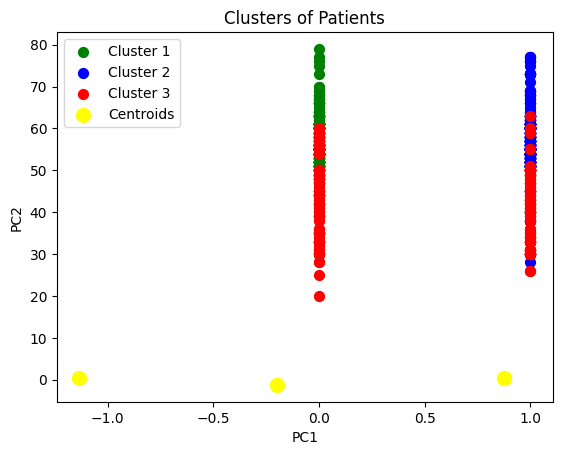

In [63]:
#visualizing gthe result
plt.scatter(means_data[labels == 0, 0], means_data[labels == 0, 1], s = 50, c = 'green', label = 'Cluster 1')
plt.scatter(means_data[labels == 1, 0], means_data[labels == 1, 1], s = 50, c = 'blue', label = 'Cluster 2')
plt.scatter(means_data[labels == 2, 0], means_data[labels == 2, 1], s = 50, c = 'red', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters of Patients')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

In [64]:
data_with_scale = reduced_means.copy()

In [65]:
data_with_scale

,Gender,AGE,HbA1c,Chol,TG,VLDL,BMI,HDL,LDL,Cluster,CLASS
0,-1.139671,0.735886,0.876065,-0.202000,1.178450,-0.014938,1.899629,-0.461684,0.350107,0,2
1,-1.139671,-2.675205,-0.387391,0.797165,-0.392445,-0.288030,-1.729472,0.598788,0.798721,2,2
2,0.877446,-0.173738,0.876065,0.643447,0.892833,0.039680,0.085078,-0.310188,-0.816289,1,2
3,0.877446,0.053668,-0.111010,-0.278859,-0.106828,-0.233412,-0.721389,-1.067668,0.439830,1,2
4,0.877446,0.963292,-0.624289,0.336011,-0.249637,-0.260721,0.105240,-0.310188,0.798721,1,2
...,...,...,...,...,...,...,...,...,...,...,...
995,0.877446,0.167371,0.876065,-0.202000,-0.606658,-0.342649,0.085078,-0.613180,-0.457398,1,2
996,0.877446,-1.538175,-1.019119,1.258318,1.035641,-0.042247,0.286695,-0.310188,1.157612,2,1
997,0.877446,-1.765581,0.757616,0.259153,-0.249637,3.316787,3.512562,-0.158692,0.529553,1,2
998,0.877446,0.735886,0.283820,0.797165,0.750024,-0.369958,0.085078,-0.613180,0.978167,1,2


In [ ]:
data_with_scale = scaler.fit_transform(data_db)

In [67]:
unscaled_data = reduced

In [68]:
unscaled_acc = acc_score(unscaled_data, label_db)

In [69]:
unscaled_acc

,Classifier,Accuracy
0,Random Forest,0.984
1,KNeighbors,0.940
2,Support vector Machine,0.896


In [71]:
scaled_data = pd.DataFrame(scaled)

In [73]:
scaled_data['CLASS'] = reduced.CLASS

In [74]:
scaled_data

,Gender,AGE,HbA1c,Chol,TG,VLDL,BMI,HDL,LDL,CLASS
0,-1.139671,0.735886,0.876065,-0.202000,1.178450,-0.014938,1.899629,-0.461684,0.350107,2
1,-1.139671,-2.675205,-0.387391,0.797165,-0.392445,-0.288030,-1.729472,0.598788,0.798721,2
2,0.877446,-0.173738,0.876065,0.643447,0.892833,0.039680,0.085078,-0.310188,-0.816289,2
3,0.877446,0.053668,-0.111010,-0.278859,-0.106828,-0.233412,-0.721389,-1.067668,0.439830,2
4,0.877446,0.963292,-0.624289,0.336011,-0.249637,-0.260721,0.105240,-0.310188,0.798721,2
...,...,...,...,...,...,...,...,...,...,...
995,0.877446,0.167371,0.876065,-0.202000,-0.606658,-0.342649,0.085078,-0.613180,-0.457398,2
996,0.877446,-1.538175,-1.019119,1.258318,1.035641,-0.042247,0.286695,-0.310188,1.157612,1
997,0.877446,-1.765581,0.757616,0.259153,-0.249637,3.316787,3.512562,-0.158692,0.529553,2
998,0.877446,0.735886,0.283820,0.797165,0.750024,-0.369958,0.085078,-0.613180,0.978167,2


In [76]:
scaled_acc = acc_score(scaled_data, label_db)

In [77]:
scaled_acc

,Classifier,Accuracy
0,Random Forest,0.984
1,Support vector Machine,0.952
2,KNeighbors,0.948


In [89]:
X_train, X_test, Y_train, Y_test = split(reduced, label_db)

In [88]:
reduced

,Gender,AGE,HbA1c,Chol,TG,VLDL,BMI,HDL,LDL,CLASS
0,0,60,10.5,4.6,4.0,1.8,39.0,0.9,3.0,2
1,0,30,7.3,5.9,1.8,0.8,21.0,1.6,3.5,2
2,1,52,10.5,5.7,3.6,2.0,30.0,1.0,1.7,2
3,1,54,8.0,4.5,2.2,1.0,26.0,0.5,3.1,2
4,1,62,6.7,5.3,2.0,0.9,30.1,1.0,3.5,2
...,...,...,...,...,...,...,...,...,...,...
995,1,55,10.5,4.6,1.5,0.6,30.0,0.8,2.1,2
996,1,40,5.7,6.5,3.8,1.7,31.0,1.0,3.9,1
997,1,38,10.2,5.2,2.0,14.0,47.0,1.1,3.2,2
998,1,60,9.0,5.9,3.4,0.5,30.0,0.8,3.7,2


In [115]:
testmodel = RandomForestClassifier()
testmodel.fit(X_train, Y_train)
y_pred = testmodel.predict(X_test)

In [110]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
cm = confusion_matrix(Y_test, y_pred, labels = ['Y', 'N', 'P'])

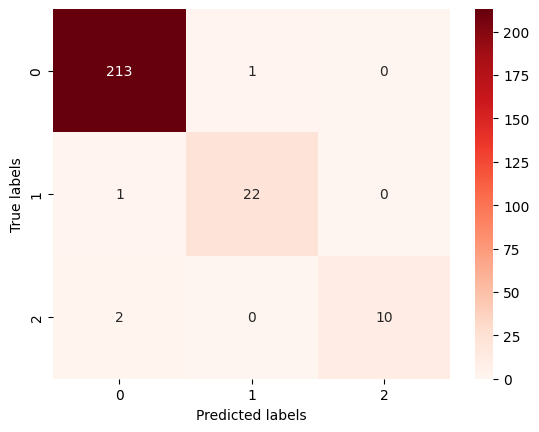

In [114]:
# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

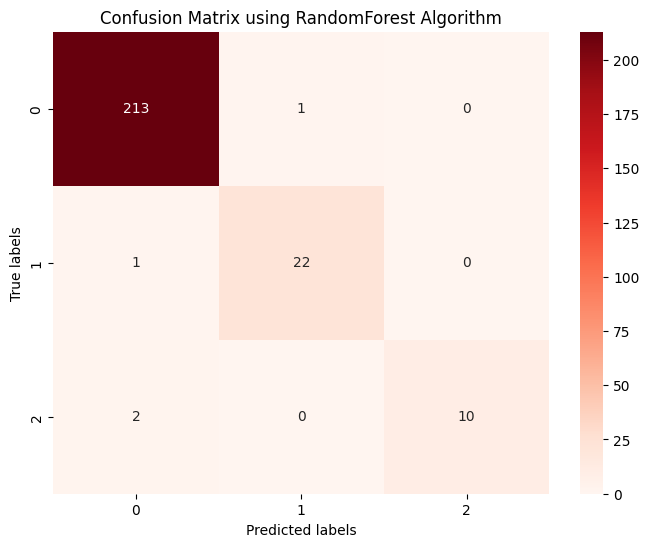

In [117]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the model
testmodel = RandomForestClassifier()
testmodel.fit(X_train, Y_train)

# Make predictions
y_pred = testmodel.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred, labels=['Y', 'N', 'P'])

# Plot confusion matrix heatmap with title
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, cmap='Reds', fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix using RandomForest Algorithm')
plt.show()

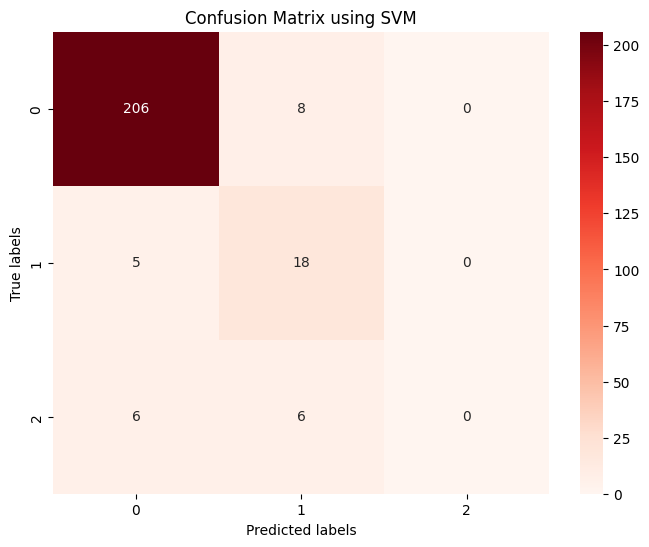

In [118]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the model
testmodel = SVC()
testmodel.fit(X_train, Y_train)

# Make predictions
y_pred = testmodel.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred, labels=['Y', 'N', 'P'])

# Plot confusion matrix heatmap with title
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, cmap='Reds', fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix using SVM')
plt.show()


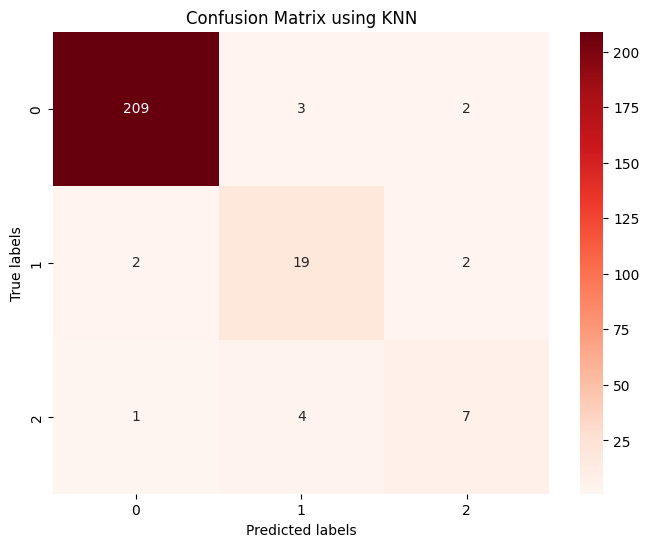

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the model
testmodel = KNeighborsClassifier()
testmodel.fit(X_train, Y_train)

# Make predictions
y_pred = testmodel.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred, labels=['Y', 'N', 'P'])

# Plot confusion matrix heatmap with title
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm, annot=True, cmap='Reds', fmt='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix using KNN')
plt.show()


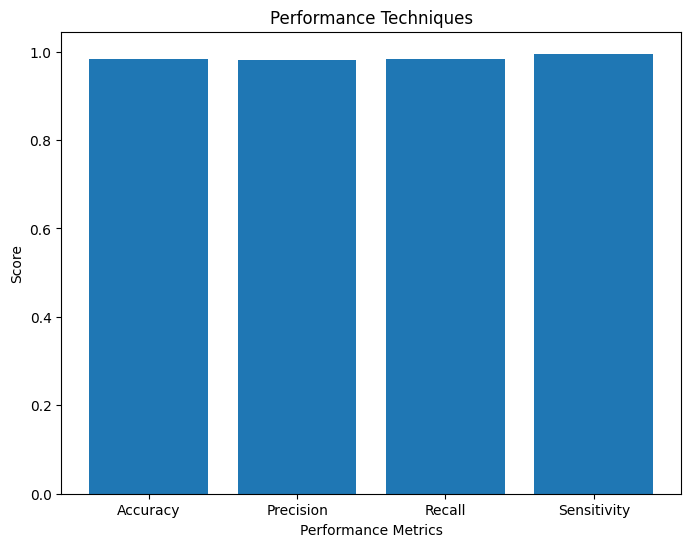

In [120]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Train the model
testmodel = RandomForestClassifier()
testmodel.fit(X_train, Y_train)

# Make predictions
y_pred = testmodel.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred, labels=['Y', 'N', 'P'])

# Calculate performance metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Create a list of metric names and values
metrics = ['Accuracy', 'Precision', 'Recall', 'Sensitivity']
values = [accuracy, precision, recall, sensitivity]

# Plot the bar chart
plt.figure(figsize=(8, 6))
plt.bar(metrics, values)
plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Performance Techniques')
plt.show()


In [ ]:
#X_train, X_test, Y_train, Y_test = split(scaled_data, label_db)

In [96]:
chromo_df_bc,score_bc=generations(scaled_data,label_db,size=80,n_feat= X_train.shape[1], n_parents=64,mutation_rate=0.20,n_gen=5, X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

Best score in generation 1 : [0.988]
Best score in generation 2 : [0.988]
Best score in generation 3 : [0.992]
Best score in generation 4 : [0.988]
Best score in generation 5 : [0.992]


In [102]:
X_train.columns

Index(['Gender', 'AGE', 'HbA1c', 'Chol', 'TG', 'VLDL', 'BMI', 'HDL', 'LDL'], dtype='object')

In [106]:
def demo():
  arr = []
  gender = float(input('Enter the patients gender here: (Female: 0, Male: 1)'))
  age = float(input('Enter your age here: (Max: 80, Min 20) '))
  HbA1c = float(input('Input your average blood sugar level for the past 2 - 3 months: (Max: 16, Min 0.9) '))
  Chol = float(input('Input your level of cholesterol here: (Max: 10.3, Min: 0) '))
  TG = float(input("Enter your triglycerides here: (Min : 0.3, Max 13.8) "))
  VLDL = float(input('Enter the value of low density lipoprotein : (Max:35, Min 0.1) '))
  BMI = float(input("Enter the value of the body mass index: (Max : 47.75, Min : 19) "))
  HDL = float(input("Enter the value of the HDL : (Max : 9.9, Min : 0.2) "))
  LDL = float(input("Enter the value of the LDL here : (Max : 9.9, Min 0.3)"))
  arr.append([gender, age, HbA1c, Chol, TG, VLDL, BMI, HDL, LDL])
  model = RandomForestClassifier()
  model.fit(X_train, Y_train)
  result = model.predict(arr)
  print(" ")
  print("Below are the details of your diabetes test result ")
  print("")
  print("")
  print("Gender : ", gender)
  print("Age : ", age)
  print("HbA1c : ", HbA1c)
  print("Cholesterol : ", Chol)
  print("TG : ", TG)
  print("VLDL : ", VLDL)
  print("BMI : ", BMI)
  print("HDL : ", HDL)
  print("LDL : ", LDL)

  print("")
  print("")
  print("Diabetes Status : ", ["Positive" if result == 'P' else "Negative" if result == 'N' else "Pre-diabetes" for result in result])

In [108]:
demo()

Enter the patients gender here: (Female: 0, Male: 1)1
Enter your age here: (Max: 80, Min 20) 78
Input your average blood sugar level for the past 2 - 3 months: (Max: 16, Min 0.9) 15
Input your level of cholesterol here: (Max: 10.3, Min: 0) 10
Enter your triglycerides here: (Min : 0.3, Max 13.8) 0.5
Enter the value of low density lipoprotein : (Max:35, Min 0.1) 35
Enter the value of the body mass index: (Max : 47.75, Min : 19) 12
Enter the value of the HDL : (Max : 9.9, Min : 0.2) 9.1
Enter the value of the LDL here : (Max : 9.9, Min 0.3)0.5
 
Below are the details of your diabetes test result 


Gender :  1.0
Age :  78.0
HbA1c :  15.0
Cholesterol :  10.0
TG :  0.5
VLDL :  35.0
BMI :  12.0
HDL :  9.1
LDL :  0.5


Diabetes Status :  ['Pre-diabetes']
